In [1]:
import glob
import os
import sys
from pathlib import Path

import numpy as np
import torch

# 当前目录
current_dir = os.path.dirname(os.path.abspath("__file__"))
# 上一级目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)
# 上两级目录
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))
sys.path.append(grandparent_dir)

from config_plot import *
from data import get_data
from network import PINN
from utils import (
    Logger,
    count_parameters,
    from_pickle,
    load_network,
    read_config_file,
    set_random_seed,
    tensors_to_numpy,
    to_pickle,
)

In [2]:
import scipy.io

# config

In [3]:
######################################################################
#
# env config
#
######################################################################
# Env
set_random_seed(random_seed=0)
os.makedirs(output_dir, exist_ok=True)

# Logger
logger = Logger(output_dir)

# Config
config_file_path = "/home/lbu/project/pinn_vibration/ex_burgers/config.py"
config = read_config_file(config_file_path)

# function

# infer

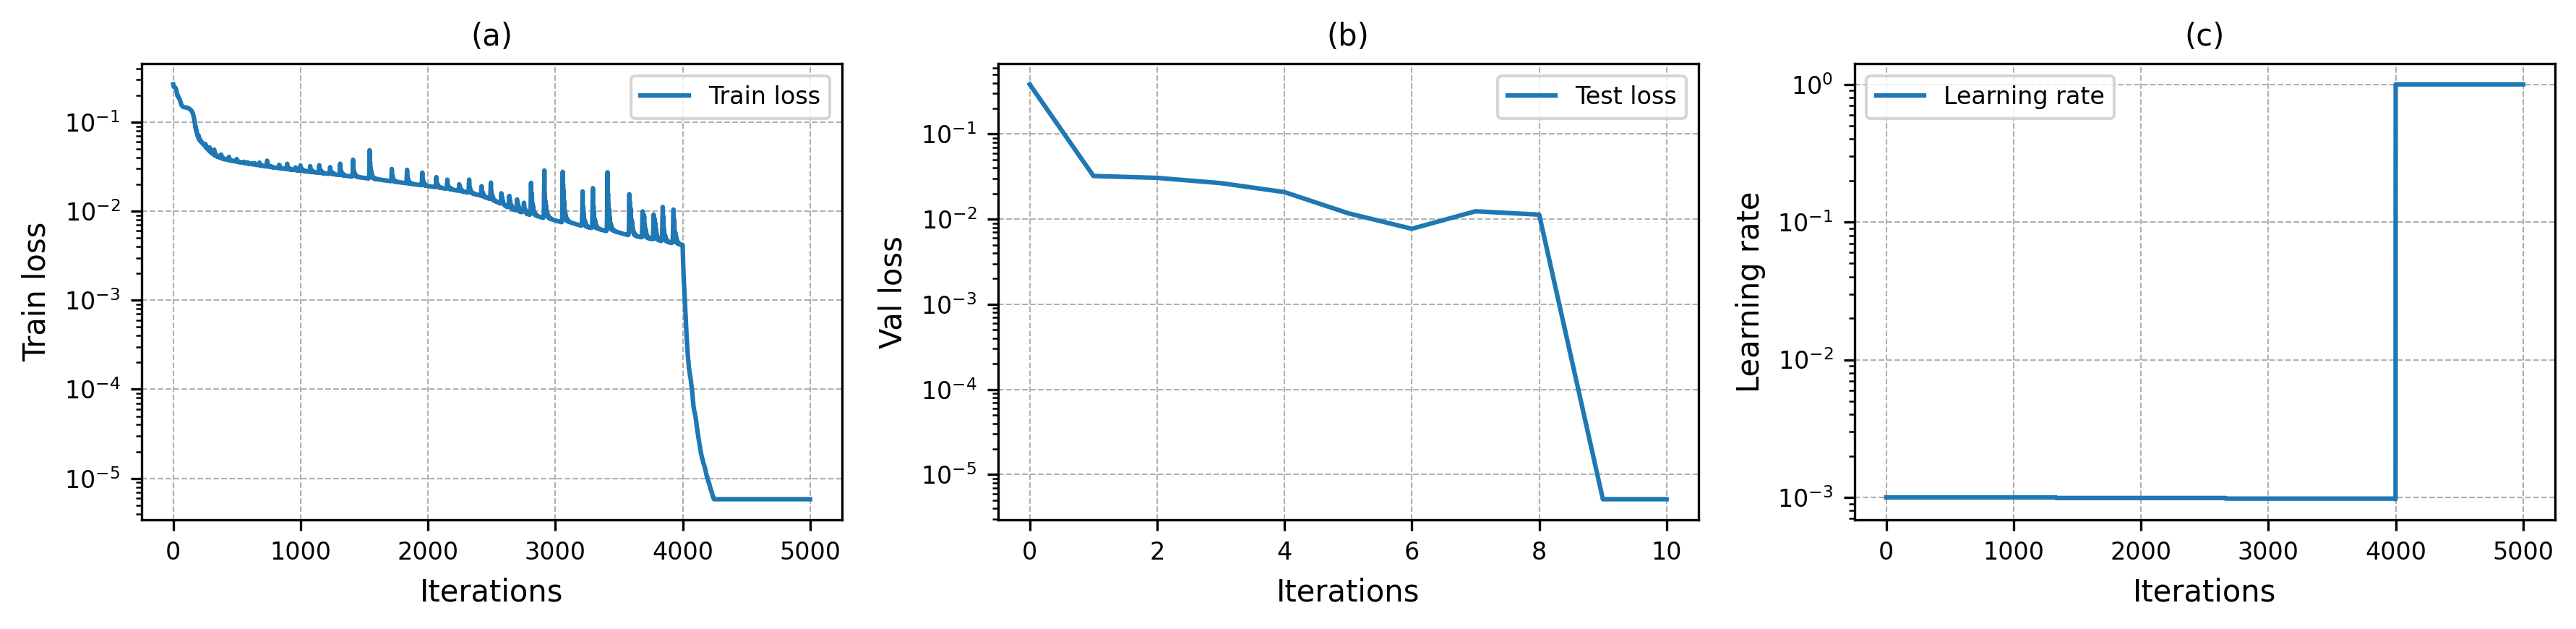

In [4]:
######################################################################
#
# plot loss
#
######################################################################
path = "/home/lbu/project/pinn_vibration/ex_burgers/outputs/loss.pkl"
loss_info = from_pickle(path)
iterations = loss_info["iter"]
train_loss = loss_info["train_loss"]
val_loss = loss_info["val_loss"]
learning_rate = loss_info["learning_rate"]

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 3 * 1), dpi=Latex_DPI)

subfig = axs[0]
subfig.set_title("(a)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Train loss")
subfig.plot(iterations, train_loss, label="Train loss")
subfig.set_yscale("log")
subfig.legend()

subfig = axs[1]
subfig.set_title("(b)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Val loss")
subfig.plot(val_loss, label="Test loss")
subfig.set_yscale("log")
subfig.legend()

subfig = axs[2]
subfig.set_title("(c)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Learning rate")
subfig.set_yscale("log")
subfig.plot(iterations, learning_rate, label="Learning rate")
subfig.legend()

plt.tight_layout()

path = os.path.join(output_dir, "loss_curve.png")
plt.savefig(path)

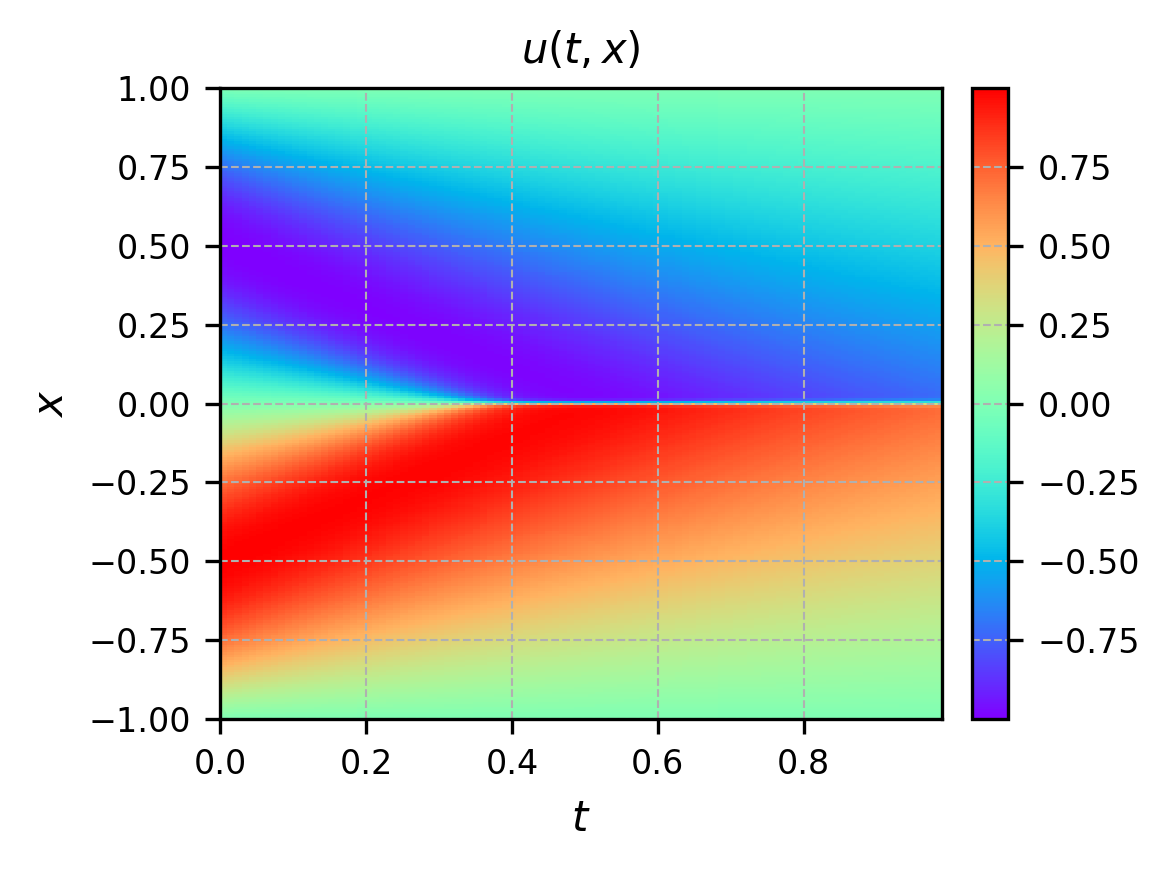

In [5]:
path = "/home/lbu/project/pinn_vibration/ex_burgers/dataset/burgers_shock.mat"
data = scipy.io.loadmat(path)

t = data["t"].flatten()[:, None]
x = data["x"].flatten()[:, None]
Exact = np.real(data["usol"])

fig, axs = plt.subplots(1, 1, figsize=(4 * 1, 3 * 1), dpi=Latex_DPI)
subfig = axs
subfig.set_title("$u(t,x)$")
subfig.set_xlabel("$t$")
subfig.set_ylabel("$x$")
h = subfig.imshow(
    Exact,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(subfig)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
subfig.tick_params()

plt.tight_layout()

path = os.path.join(output_dir, "GT.png")
plt.savefig(path)

2023-10-05 16:23:14 INFO Number of parameters in model: 3440
2023-10-05 16:23:14 INFO Dataset generated at: /home/lbu/project/pinn_vibration/ex_burgers/dataset/burgers-dataset.pkl
2023-10-05 16:23:14 INFO Congratulations, the dataset is generated!
2023-10-05 16:23:14 INFO MSE error is: 5.137753760209307e-06


Successfully loaded pretrained weights from "/home/lbu/project/pinn_vibration/ex_burgers/outputs/model.tar"
'get_data' took 0.00 minute 


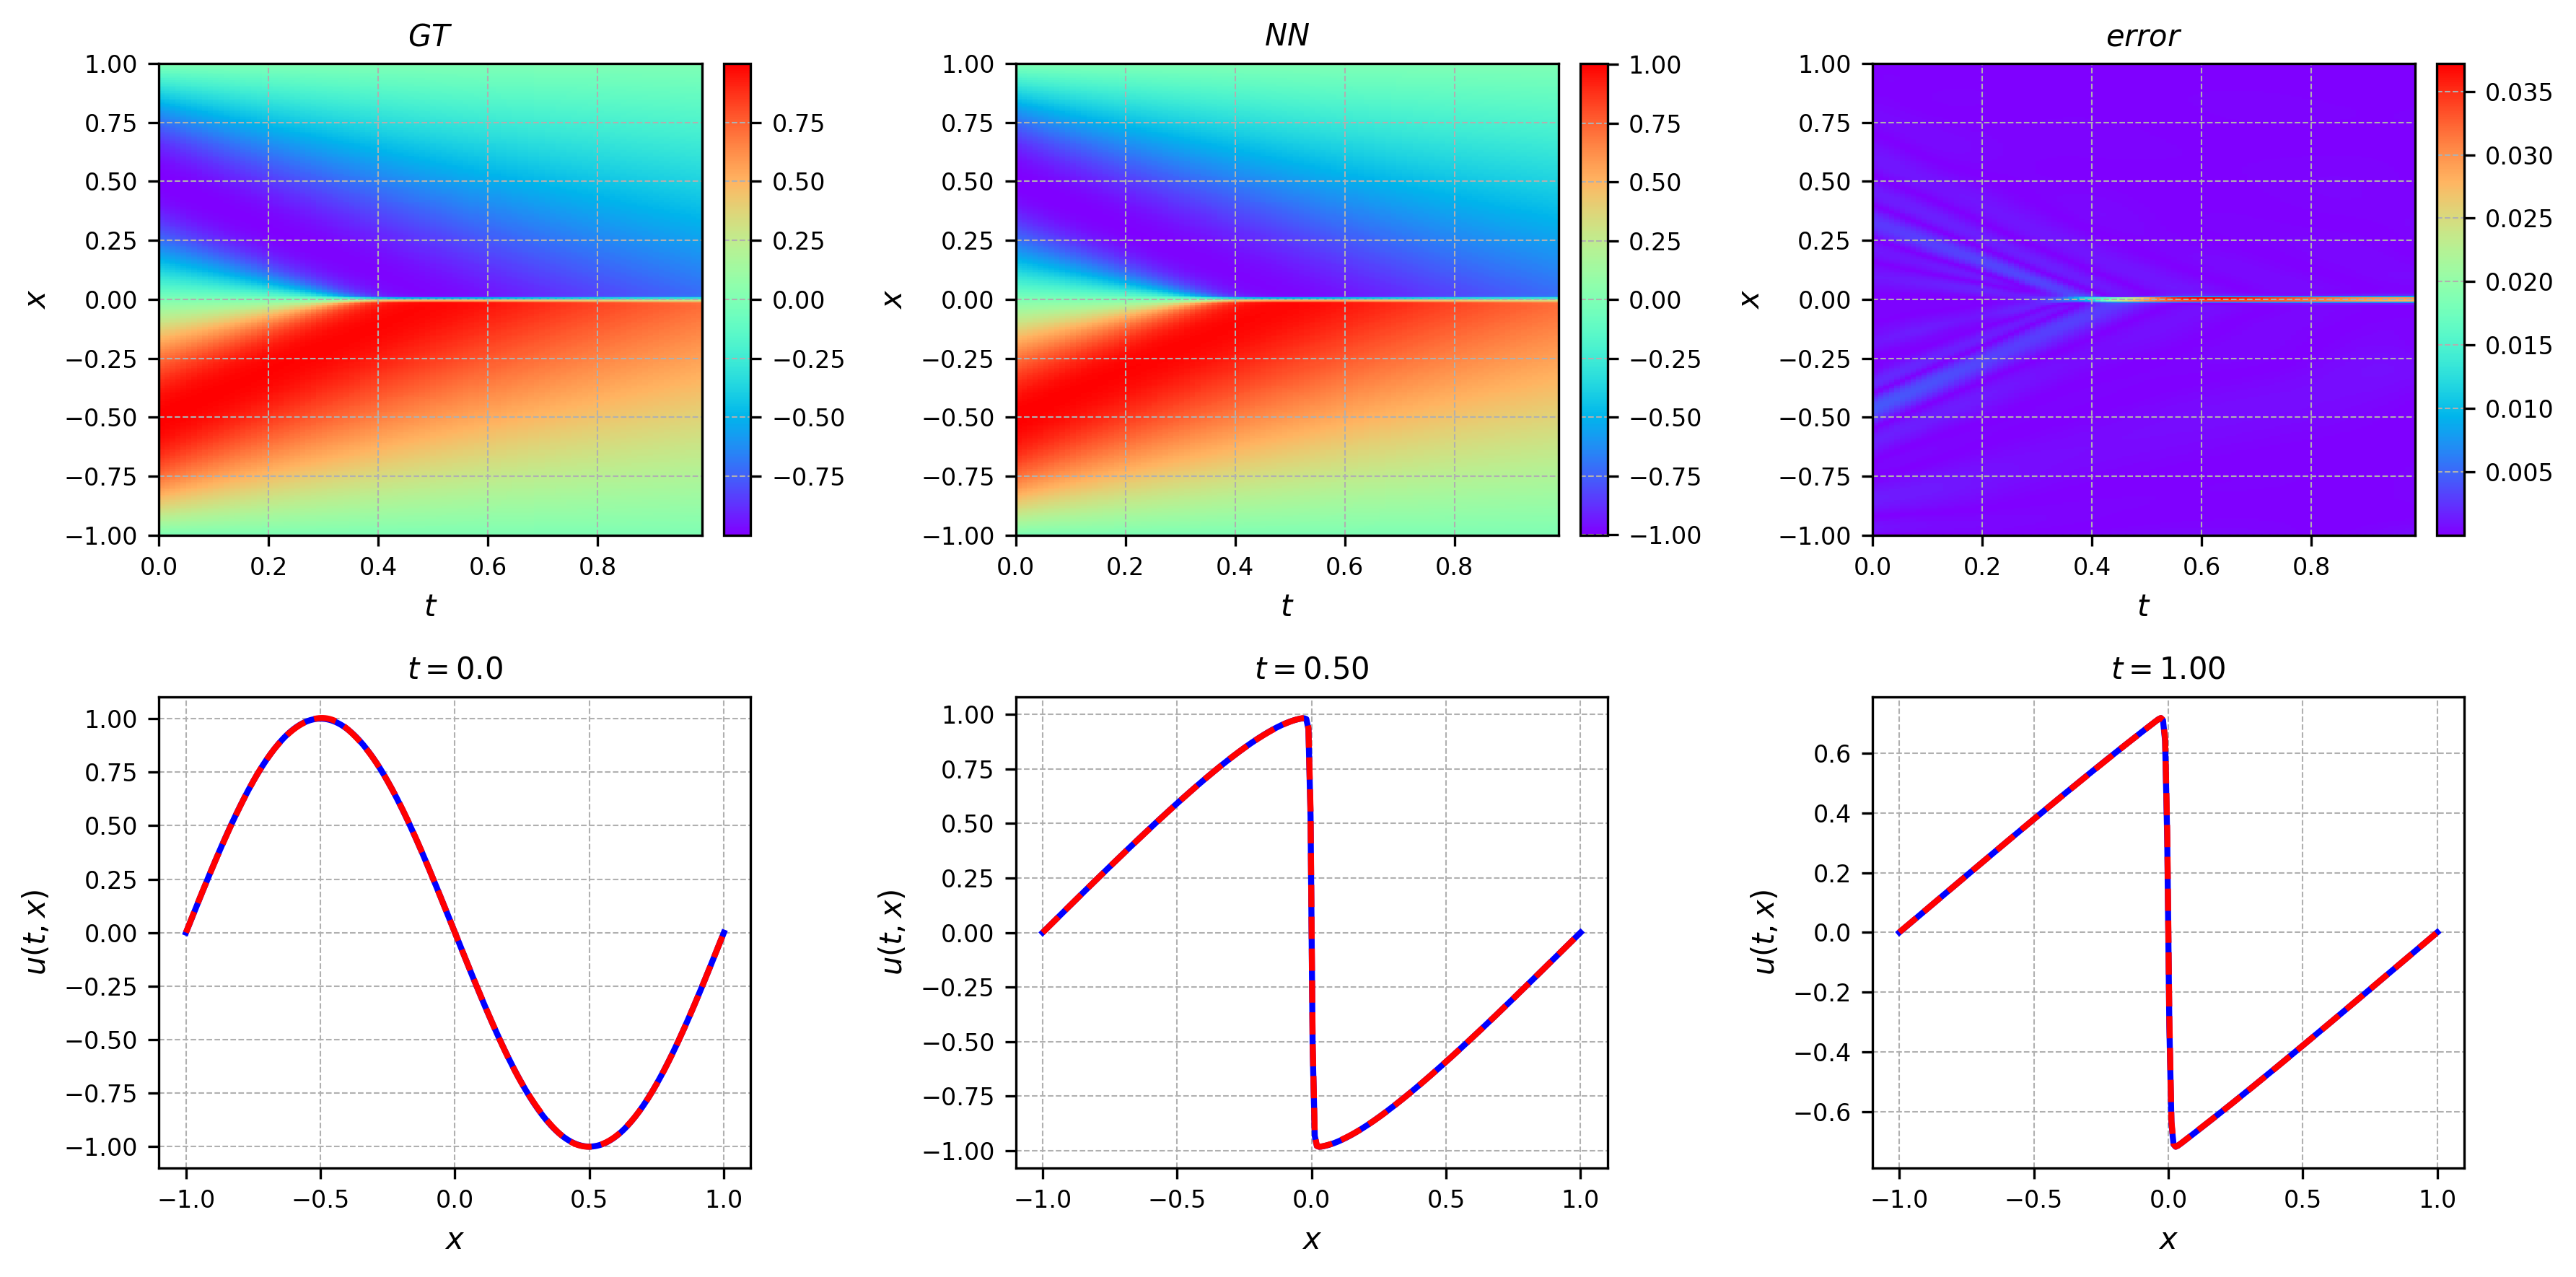

In [8]:
######################################################################
#
# network
#
######################################################################
# get model
model = PINN(config, logger).to(config.device, config.dtype)
path = "/home/lbu/project/pinn_vibration/ex_burgers/outputs/model.tar"
load_network(model, path, config.device)
logger.info("Number of parameters in model: {}".format(count_parameters(model)))

# get data
train_data, eval_data = get_data(config, logger)

# model prediction
u_pred, error = model.eval(eval_data)
logger.info("MSE error is: {}".format(error.item()))

# to numpy
u_pred = tensors_to_numpy(u_pred).reshape(256, 100)
err_img = np.abs(u_pred - Exact)

# plot
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title("$GT$")
subfig.set_xlabel("$t$")
subfig.set_ylabel("$x$")
h = subfig.imshow(
    Exact,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(subfig)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
subfig.tick_params()

subfig = axs[0, 1]
subfig.set_title("$NN$")
subfig.set_xlabel("$t$")
subfig.set_ylabel("$x$")
h = subfig.imshow(
    u_pred,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(subfig)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
subfig.tick_params()


subfig = axs[0, 2]
subfig.set_title("$error$")
subfig.set_xlabel("$t$")
subfig.set_ylabel("$x$")
h = subfig.imshow(
    err_img,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(subfig)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
subfig.tick_params()

subfig = axs[1, 0]
subfig.set_title("$t=0.0$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, Exact[:, 0], "b-", linewidth=2, label="Exact")
subfig.plot(x, u_pred[:, 0], "r--", linewidth=2, label="Prediction")

subfig = axs[1, 1]
subfig.set_title("$t=0.50$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, Exact[:, 50], "b-", linewidth=2, label="Exact")
subfig.plot(x, u_pred[:, 50], "r--", linewidth=2, label="Prediction")

subfig = axs[1, 2]
subfig.set_title("$t=1.00$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, Exact[:,-1], "b-", linewidth=2, label="Exact")
subfig.plot(x, u_pred[:,-1], "r--", linewidth=2, label="Prediction")

plt.tight_layout()

path = os.path.join(output_dir, "Burgers_results.png")
plt.savefig(path)